In [1]:
import sys

from dotenv import load_dotenv
sys.path.insert(0, os.path.abspath('../src'))
print(sys.path)

load_dotenv()

['/home/yannik/coding-native/LLMsAgents-TextToSQL/src', '/home/linuxbrew/.linuxbrew/Cellar/python@3.13/3.13.0_1/lib/python313.zip', '/home/linuxbrew/.linuxbrew/Cellar/python@3.13/3.13.0_1/lib/python3.13', '/home/linuxbrew/.linuxbrew/Cellar/python@3.13/3.13.0_1/lib/python3.13/lib-dynload', '', '/home/yannik/.cache/pypoetry/virtualenvs/llmsagents-texttosql-L08Ttfzn-py3.13/lib/python3.13/site-packages']


True

In [2]:
import pandas as pd

data = pd.read_json('../data/dev/dev.json')

data.head()

,question_id,db_id,question,evidence,SQL,difficulty
0,0,california_schools,What is the highest eligible free rate for K-1...,Eligible free rate for K-12 = `Free Meal Count...,SELECT `Free Meal Count (K-12)` / `Enrollment ...,simple
1,1,california_schools,Please list the lowest three eligible free rat...,Eligible free rates for students aged 5-17 = `...,SELECT `Free Meal Count (Ages 5-17)` / `Enroll...,moderate
2,2,california_schools,Please list the zip code of all the charter sc...,Charter schools refers to `Charter School (Y/N...,SELECT T2.Zip FROM frpm AS T1 INNER JOIN schoo...,simple
3,3,california_schools,What is the unabbreviated mailing street addre...,,SELECT T2.MailStreet FROM frpm AS T1 INNER JOI...,simple
4,4,california_schools,Please list the phone numbers of the direct ch...,Charter schools refers to `Charter School (Y/N...,SELECT T2.Phone FROM frpm AS T1 INNER JOIN sch...,moderate


In [3]:
data.count()

question_id    1534
db_id          1534
question       1534
evidence       1534
SQL            1534
difficulty     1534
dtype: int64

In [4]:
from langchain_ollama.chat_models import ChatOllama
from agents.feedback_agent import FeedbackAgent

model_name = "mistral"
llm = ChatOllama(model=model_name)
agent = FeedbackAgent(llm)

In [5]:
start = 89
end = 100

In [ ]:
from tqdm.notebook import tqdm

evaluation = []
for row in tqdm(
    data[start:end].itertuples(index=False),
    total=len(data[start:end]),
    initial=start,
    desc=f"Evaluating {model_name}: ",
):
    response = agent.evaluate_query(
        database=row.db_id, original_question=row.question, generated_sql_query=row.SQL
    )
    if response:
        is_correct = response["is_correct"]
        successful_run = response["query_result"] != "error"
        feedback = response["feedback"]
    else:
        is_correct = False
        successful_run = False
        feedback = "LLM Failure"

    evaluation.append(
        {
            "question_id": row.question_id,
            "is_correct": is_correct,
            "difficulty": row.difficulty,
            "successful_run": successful_run,
            "feedback": feedback,
        }
    )

Evaluating mistral: : 89it [00:00, ?it/s]

In [7]:
df = pd.DataFrame(evaluation)
df.to_csv(f"./runs/{model_name}/batch_{start}_{end}.csv", index=False)

In [15]:
import os
import glob

# Define the path to the batch files
batch_files_path = "./runs/mistral/batch_*.csv"

# Get a list of all batch files
batch_files = glob.glob(batch_files_path)

# Read and concatenate all batch files
final_df = pd.concat((pd.read_csv(f) for f in batch_files), ignore_index=True)

# Sort the final DataFrame by question_id
final_df = final_df.sort_values(by="question_id")

# Save the final DataFrame to a new CSV file
final_df.to_csv("./runs/mistral/final_evaluation.csv", index=False)

In [16]:
accuracy = final_df["is_correct"].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 45.00%


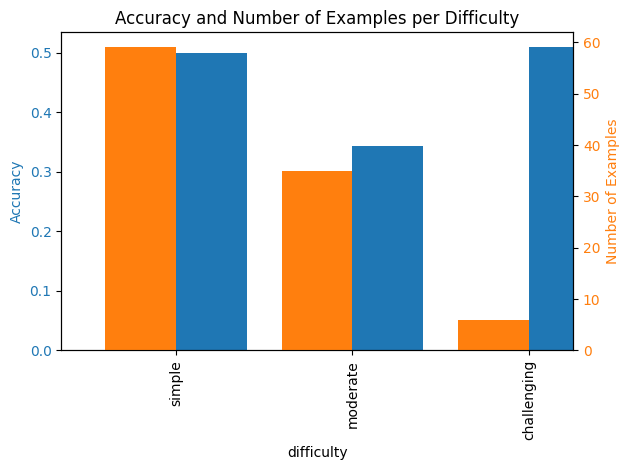

In [18]:
import matplotlib.pyplot as plt

# Calculate accuracy per difficulty
accuracy_per_difficulty = final_df.groupby("difficulty")["is_correct"].mean()

# Calculate number of examples per difficulty
examples_per_difficulty = final_df["difficulty"].value_counts()

fig, ax1 = plt.subplots()

# Plot accuracy per difficulty
color = "tab:blue"
ax1.set_xlabel("Difficulty")
ax1.set_ylabel("Accuracy", color=color)
accuracy_per_difficulty.plot(kind="bar", ax=ax1, color=color, position=0, width=0.4)
ax1.tick_params(axis="y", labelcolor=color)

# Create a secondary y-axis to plot the number of examples
ax2 = ax1.twinx()
color = "tab:orange"
ax2.set_ylabel("Number of Examples", color=color)
examples_per_difficulty.plot(kind="bar", ax=ax2, color=color, position=1, width=0.4)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Accuracy and Number of Examples per Difficulty")
fig.tight_layout()
plt.show()